In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

%run './../split_step_fourier.ipynb'

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size': 12}
figure_size = (25, 15)
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [2]:
# parameters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

power = 5 # dBm

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 30 # number of symbols


# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)


# Sendesignal generieren
send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt, power)

# add zeros before and after signal (use samples per symbol as factor)
send_new = zeroing(send_rc, 5 * int(1/f_symbol/t_sample_rc))

In [19]:
## Transmission parameters
full_distance = 770

z_length = 70  # [km]
nz = 10  # steps
dz = z_length / nz  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [22]:
output = splitstepfourier(send_new, t_sample_rc, dz, nz, alpha, beta2, gamma, True)

# init arrays for plotting with values at 0 input
power_full_distance = [np.power(10, (power-30)/10)]
xvals_full_distance = [0.0]

# put an amplifier every z_length km in the fiber
next_input = send_new

for segment in range(int(full_distance / z_length)):
    segment_output = splitstepfourier(next_input, t_sample_rc, dz, nz, alpha, beta2, gamma, True)
    segment_power = [np.real(np.sum(np.square(val))*t_sample_rc/(1/f_symbol)) for val in segment_output.values()]
    segment_xvals = [float(key)*dz + segment * z_length for key in segment_output.keys()]
    next_input = amplifier(segment_output[f"{str(nz)}"], power, t_sample_rc, 1/f_symbol)
    
    power_full_distance += segment_power
    xvals_full_distance += segment_xvals

if full_distance % z_length != 0:
    rest_z_length = full_distance % z_length
    rest_dz = rest_z_length / nz
    rest_output = splitstepfourier(next_input, t_sample_rc, rest_dz, nz, alpha, beta2, gamma, True)
    rest_power = [np.real(np.sum(np.square(val))*t_sample_rc/(1/f_symbol)) for val in segment_output.values()]
    rest_xvals = [float(key)*rest_dz + int(full_distance / z_length) * z_length for key in segment_output.keys()]
    
    power_full_distance += rest_power
    xvals_full_distance += rest_xvals
    

print(power_full_distance)
print(xvals_full_distance)

[0.0031622776601683794, 0.0015292714418439846, 0.00030444617575012446, 4.828131361330056e-05, 5.769119046215762e-06, 4.655566536100522e-07, 4.206310232186796e-08, 2.2426719067598754e-08, 1.2485307310393785e-08, 5.146603829431341e-09, 1.7764503238241534e-09, 9.989470146933315e-10, 0.0017219884691754004, 0.000465421672436728, 0.00010834926950148274, 2.095904871861108e-05, 3.1656487101301992e-06, 3.4377753898637716e-07, 3.4687164139168404e-08, 1.2096092715226234e-08, 6.1229512680095035e-09, 2.215797021186095e-09, 1.179972940664529e-09, 0.0016472384710293755, 0.00038830926742330175, 8.179704478806614e-05, 1.7923050455372567e-05, 4.547462806295031e-06, 1.2342781946946958e-06, 3.260156811467547e-07, 8.421150577279188e-08, 2.1899674612129627e-08, 5.924152379024749e-09, 3.1523932656188246e-09, 0.0016902065906253287, 0.000471090411456874, 0.0001185845113160069, 2.520696580064878e-05, 4.202408839736094e-06, 5.187141971555068e-07, 6.317931156222503e-08, 2.2590292389830817e-08, 1.1884145327221826e

/home/dominik/.virtualenvs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


(0.0, 770.0)

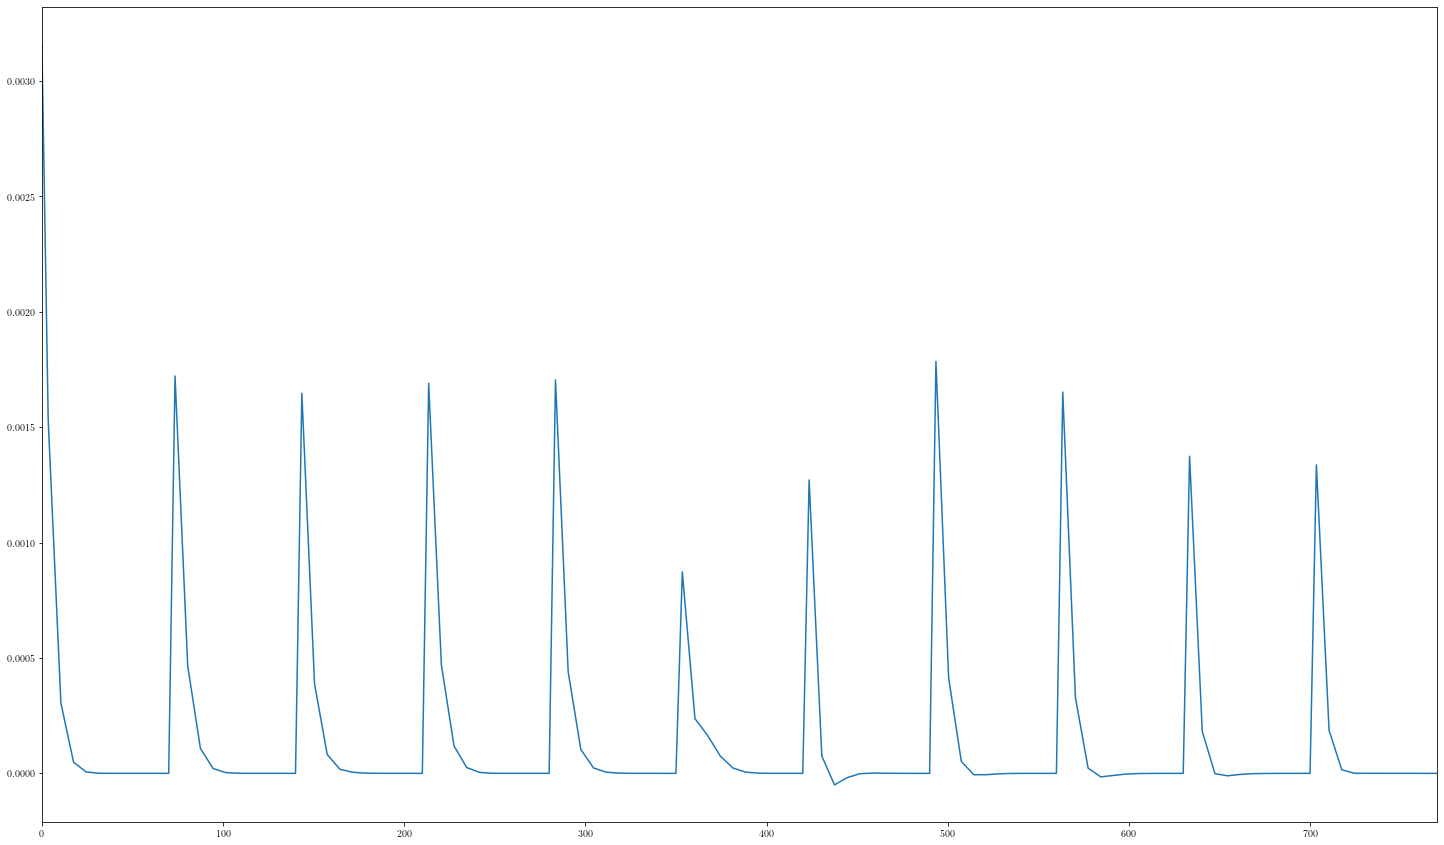

In [23]:
fig1, ax1 = plt.subplots(1, figsize=figure_size, sharex=True)

ax1.plot(xvals_full_distance, power_full_distance)
ax1.set_xlim(np.amin(xvals_full_distance), np.amax(xvals_full_distance))